In [94]:
# Import tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# For anova tukey analysis
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
%matplotlib inline

In [95]:
# Read in data
wdi = pd.read_csv('WDI_csv/wrangled/wdi.csv')
wdi_pivot = pd.read_csv('WDI_csv/wrangled/wdi_pivot.csv')
wdi_pivot = wdi_pivot.sort_values(['country', 'year', 'income_group'])

# Forward fill missing values for one feature for line plot value label #-#
wdi_pivot.iloc[:,230] = wdi_pivot.iloc[:,230].fillna(method='ffill')

# Filter data by income group
high = wdi_pivot[wdi_pivot.income_group == 'High income']
upper_middle = wdi_pivot[wdi_pivot.income_group == 'Upper middle income']
lower_middle = wdi_pivot[wdi_pivot.income_group == 'Lower middle income']
low = wdi_pivot[wdi_pivot.income_group == 'Low income']

income_groups = [high, upper_middle, lower_middle, low]

In [4]:
# There are 203 countries and 341 indicators

In [5]:
# 2436 Total
wdi_pivot.income_group.value_counts()

High income            787
Lower middle income    616
Upper middle income    564
Low income             469
Name: income_group, dtype: int64

## Define Functions

In [96]:
# Empirical cumulative distribution functions
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [97]:
def time_change():
    # Order income groups in a list
    sorted_income_groups = ['High income', 'Upper middle income', 
                            'Lower middle income', 'Low income']
    
    # Get df ready to become a percentage stacked bar chart
    percent = wdi_pivot.groupby(
        ['year', 'income_group'])['year'].count().unstack('income_group')/203*100
    
    # Sort df by income groups
    percent.columns = pd.CategoricalIndex(percent.columns.values, 
                                     ordered=True, 
                                     categories=sorted_income_groups)
    percent = percent.sort_index(axis=1)
    
    # Plot
    ax = percent.plot(kind='bar', stacked=True, 
                 title='Countries in Each Income Group per Year', 
                 figsize=(10,10), 
                 rot=0)
    
    # Annotate number of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(height*203/100), 
                horizontalalignment='center', 
                verticalalignment='center',
                color='white')
    
    # Annotate percent of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height-2, 
                '{:.0f}%'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center',
                alpha=0.75
               )
    
    plt.xlabel('Year')
    plt.ylabel('Percantage')
    plt.tick_params(left=False)
    plt.legend(loc='lower right')
    plt.axhline(20, color='white', alpha=0.25)
    plt.axhline(40, color='white', alpha=0.25)
    plt.axhline(60, color='white', alpha=0.25)
    plt.axhline(80, color='white', alpha=0.25)
    sns.despine(top=True, right=True)
    
    plt.show()
    
    # Make df for number and percent available
    global numbers, percents
    # df for number of countries per income group
    numbers = percent*203/100
    # df for percent of countries per income group
    percents = percent

In [110]:
def view(wdi_feature):
    """Print definition of feature
    View box plot that separates feature data into income groups.
    View summary statistics including difference in means using tukey.
    View change, year over year, of feature among income groups.
    View scatter plot that compares feature to purchasing power per capita.
    View scatter plot separated by income group.
    View pearson correlation scores between feature and purchasing power per capita."""
    
    #-----------------------------------------------------------------------
    
    # Print definition of feature
    print('Indicator Definition: \n')
    print(wdi.definition[wdi.indicator == wdi_feature].iloc[0])
    
    #-----------------------------------------------------------------------
    
    # Plot box plot
    plt.figure(figsize=(10,6))
    sns.boxplot(
        x='income_group', y=wdi_feature, 
        data=wdi_pivot, order=["High income", "Upper middle income", 
                               "Lower middle income", "Low income"]
    ).set_title(wdi_feature)
    sns.despine(right=True, top=True)
    plt.ylabel('-')
    plt.xlabel('Income Groups')
    plt.xticks(rotation=15)
    plt.show()
    
    #-----------------------------------------------------------------------
    
    # Print hypothesis
    print('''
    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    ''')
    
    # Separate data by income groups and rename columns
    wdi_describe = wdi_pivot.pivot(
        index='Unnamed: 0', columns='income_group', values=wdi_feature)
    
    wdi_describe = wdi_describe.rename(
    columns={'Upper middle income': 'Upper mid income', 
             'Lower middle income': 'Lower mid income'}
    )
    
    # Display only income groups
    wdi_describe = wdi_describe[['High income', 'Upper mid income', 
                                 'Lower mid income', 'Low income']]
    
    # Print mean of each income group
    print(wdi_describe.describe().iloc[1:2,:])
    print('\n')
    
    # Compute ANOVA Tukey Multiple Correction score
    a = wdi_feature
    mc = MultiComparison(wdi_pivot.dropna(subset=[a], axis=0)[a], 
                         wdi_pivot.dropna(subset=[a], axis=0)['income_group'])
    result = mc.tukeyhsd()
    print(result)
    print(mc.groupsunique)
    print('\n')
    
    #-----------------------------------------------------------------------
    
    # Plot year over year changes of feature for each income group

    fig, ax = plt.subplots(figsize=(10,4))
    for group in income_groups:
        ax.plot(
            'year', wdi_feature, 
            data=group.groupby('year').mean().reset_index().sort_values('year'))
        
        # Annotate first and last value
        ax.text(2005-0.5, group[wdi_feature][group.year == 2005].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2005].mean()),
               fontsize=8)
        ax.text(2016+0.1, group[wdi_feature][group.year == 2016].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2016].mean()),
               fontsize=8) #-#
        
    
    # Annotate graph
    plt.title(wdi_feature + ' from 2005 to 2016')
    plt.ylabel('Average over time')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    sns.despine(top=True, right=True)
    plt.show()
    
    #-----------------------------------------------------------------------
    
    # Set coordinates
    a = wdi_feature
    b = 'GNI per capita, Atlas method (current US$)'
    
    # Plot scatter plot for all income groups
    fig = plt.figure(figsize=(10,4))
    fig.suptitle(a + ' vs ' + b + ' from 2005 to 2016', fontsize=12)
    ax = plt.subplot(1,1,1)
    for group in income_groups:
        ax.plot(group[a], group[b], marker='.', linestyle='none')
    
    # Annotate graph
    ax.legend(('High income', 'Upper middle income', 'Lower middle income', 'Low income'), 
              loc='upper right')
    ax.set_xlabel(a)
    ax.set_ylabel(b)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    
    #-----------------------------------------------------------------------
    
    # Plot scatter plot each income group
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    # High income
    ax1.plot(
            high[a], 
            high[b], 
            marker='.', 
            linestyle='none', c='blue'
        )
    ax1.set_title('High Income')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_xlim(min(wdi_pivot[a][wdi_pivot[a].notnull()]), 
                 max(wdi_pivot[a][wdi_pivot[a].notnull()]))
    ax1.set_ylim(min(wdi_pivot[b][wdi_pivot[b].notnull()]), 
                 max(wdi_pivot[b][wdi_pivot[b].notnull()]))
    
    # Upper middle income
    ax2.plot(
            upper_middle[a], 
            upper_middle[b], 
            marker='.', 
            linestyle='none', c='coral'
        )
    ax2.set_title('Upper Middle Income')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xticks([])
    ax2.set_xlim(min(wdi_pivot[a][wdi_pivot[a].notnull()]), 
                 max(wdi_pivot[a][wdi_pivot[a].notnull()]))
    ax2.set_ylim(min(wdi_pivot[b][wdi_pivot[b].notnull()]), 
                 max(wdi_pivot[b][wdi_pivot[b].notnull()]))
    
    # Lower middle income
    ax3.plot(
            lower_middle[a], 
            lower_middle[b], 
            marker='.', 
            linestyle='none', c='green'
        )
    ax3.set_title('Lower Middle Income')
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_xlim(min(wdi_pivot[a][wdi_pivot[a].notnull()]), 
                 max(wdi_pivot[a][wdi_pivot[a].notnull()]))
    ax3.set_ylim(min(wdi_pivot[b][wdi_pivot[b].notnull()]), 
                 max(wdi_pivot[b][wdi_pivot[b].notnull()]))
    
    # Low income
    ax4.plot(
            low[a], 
            low[b], 
            marker='.', 
            linestyle='none', c='red'
        )
    ax4.set_title('Low Income')
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.set_xlim(min(wdi_pivot[a][wdi_pivot[a].notnull()]), 
                 max(wdi_pivot[a][wdi_pivot[a].notnull()]))
    ax4.set_ylim(min(wdi_pivot[b][wdi_pivot[b].notnull()]), 
                 max(wdi_pivot[b][wdi_pivot[b].notnull()]))
    
    plt.show()
    
    #---------------------------------------------
    
    # Compute correlation score
    print('{} and {} are correlated by:'.format(a,b))    
    pearson = stats.pearsonr(
        wdi_pivot[a].fillna(wdi_pivot[a].mean()), 
        wdi_pivot[b].fillna(wdi_pivot[b].mean())
        )

    print('{:.4f} with a p-value of {} among all income groups'
          .format(pearson[0], pearson[1]))


    # Compute correlation score for each income group    
    for group in income_groups:
        x = group[a].fillna(group[a].mean())
        y = group[b].fillna(group[b].mean())
        pearson = stats.pearsonr(x, y)
        
        print('{:.4f} with a p-value of {} among {} countries.'
              .format(pearson[0], pearson[1], group.income_group.iloc[0]))

### Income groups change from year to year.

Higher income groups are growing while lower income groups are shrinking from year to year.

Features are showing a growth in access and standards of living among all income groups from year to year.

These features are a result of the increasing development of the world.

Some features are correlated to income groups, while others are not.

Some features are correlated to the GNI per capita.

Some features are correlated with each other, while others are not.

## Year to Year Change in Income Groups

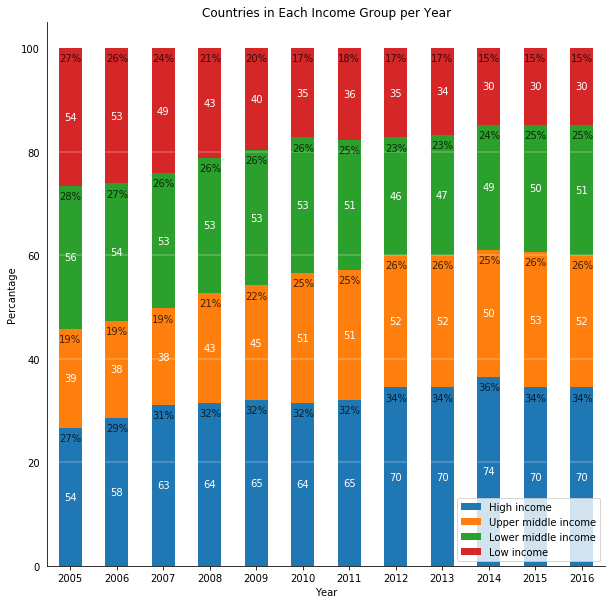

In [10]:
time_change()

In [11]:
numbers

,High income,Upper middle income,Lower middle income,Low income
year,,,,
2005,54.0,39.0,56.0,54.0
2006,58.0,38.0,54.0,53.0
2007,63.0,38.0,53.0,49.0
2008,64.0,43.0,53.0,43.0
2009,65.0,45.0,53.0,40.0
2010,64.0,51.0,53.0,35.0
2011,65.0,51.0,51.0,36.0
2012,70.0,52.0,46.0,35.0
2013,70.0,52.0,47.0,34.0


In [12]:
percents

,High income,Upper middle income,Lower middle income,Low income
year,,,,
2005,26.600985,19.211823,27.586207,26.600985
2006,28.571429,18.719212,26.600985,26.108374
2007,31.034483,18.719212,26.108374,24.137931
2008,31.527094,21.182266,26.108374,21.182266
2009,32.019704,22.167488,26.108374,19.704433
2010,31.527094,25.123153,26.108374,17.241379
2011,32.019704,25.123153,25.123153,17.733990
2012,34.482759,25.615764,22.660099,17.241379
2013,34.482759,25.615764,23.152709,16.748768


In [13]:
pd.concat([numbers,percents], axis=1)

,High income,Upper middle income,Lower middle income,Low income,High income,Upper middle income,Lower middle income,Low income
year,,,,,,,,
2005,54.0,39.0,56.0,54.0,26.600985,19.211823,27.586207,26.600985
2006,58.0,38.0,54.0,53.0,28.571429,18.719212,26.600985,26.108374
2007,63.0,38.0,53.0,49.0,31.034483,18.719212,26.108374,24.137931
2008,64.0,43.0,53.0,43.0,31.527094,21.182266,26.108374,21.182266
2009,65.0,45.0,53.0,40.0,32.019704,22.167488,26.108374,19.704433
2010,64.0,51.0,53.0,35.0,31.527094,25.123153,26.108374,17.241379
2011,65.0,51.0,51.0,36.0,32.019704,25.123153,25.123153,17.733990
2012,70.0,52.0,46.0,35.0,34.482759,25.615764,22.660099,17.241379
2013,70.0,52.0,47.0,34.0,34.482759,25.615764,23.152709,16.748768


## Indicator Correlation

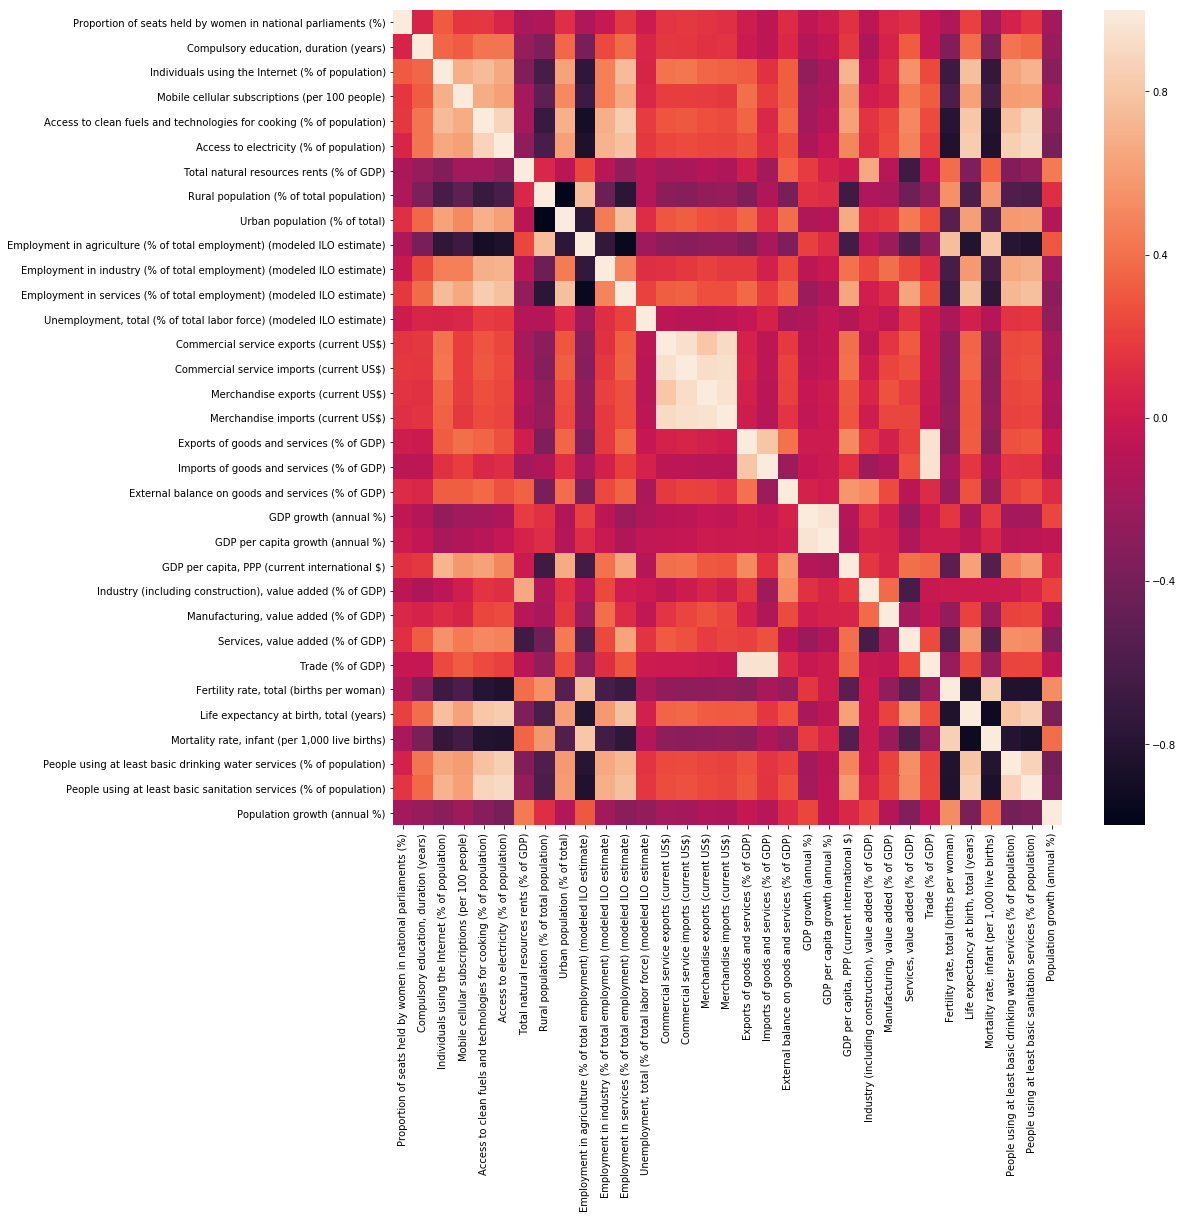

In [14]:
wdi_corr = wdi_pivot[[
    'Proportion of seats held by women in national parliaments (%)',
    'Compulsory education, duration (years)',
    'Individuals using the Internet (% of population)',
    'Mobile cellular subscriptions (per 100 people)',
    'Access to clean fuels and technologies for cooking (% of population)',
    'Access to electricity (% of population)',
    'Total natural resources rents (% of GDP)',
    'Rural population (% of total population)',
    'Urban population (% of total)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Commercial service exports (current US$)',
    'Commercial service imports (current US$)',
    'Merchandise exports (current US$)',
    'Merchandise imports (current US$)',
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)',
    'External balance on goods and services (% of GDP)',
    'GDP growth (annual %)',
    'GDP per capita growth (annual %)',
    'GDP per capita, PPP (current international $)',
    'Industry (including construction), value added (% of GDP)',
    'Manufacturing, value added (% of GDP)',
    'Services, value added (% of GDP)',
    'Trade (% of GDP)',
    'Fertility rate, total (births per woman)',
    'Life expectancy at birth, total (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)',
    'Population growth (annual %)'
]]

plt.figure(figsize=(15,15))
correlations = wdi_corr.corr()
sns.heatmap(correlations,
           xticklabels=correlations.columns.values,
           yticklabels=correlations.columns.values)
plt.show()

## Economic Policy and Debt

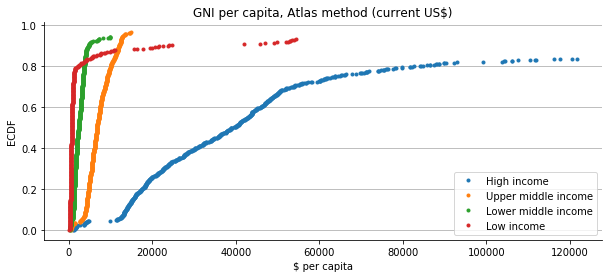

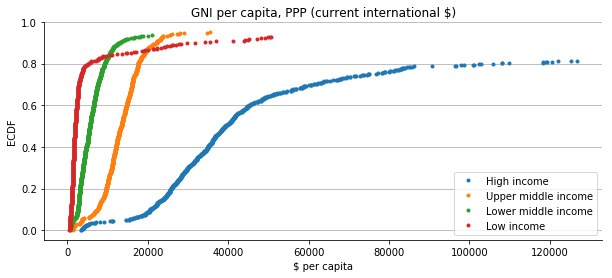

In [15]:
methods = ['GNI per capita, Atlas method (current US$)', 
           'GNI per capita, PPP (current international $)']

# Compute ECDF and generate plot
for method in methods:
    plt.figure(figsize=(10,4))
    plt.title(method)
    for group in income_groups:
        x, y = ecdf(group[method])
        plt.plot(x, y, marker='.', linestyle='none')
    
    # Annotate the plot
    plt.grid(axis='y')
    plt.legend(('High income', 'Upper middle income', 
                'Lower middle income', 'Low income'), 
               loc='lower right')
    plt.xlabel('$ per capita')
    plt.ylabel('ECDF')
    sns.despine(top=True, right=True)
    plt.show()

In [16]:
print(*list(high.country[high['GNI per capita, Atlas method (current US$)'] < 20000].head(60).unique()), sep=', ')
len(high.country[high['GNI per capita, Atlas method (current US$)'] < 20000])/len(high)

Antigua and Barbuda, Argentina, Aruba, Bahrain, Barbados, Chile, Croatia, Czech Republic, Equatorial Guinea


0.2604828462515883

In [17]:
print(*list(low.country[low['GNI per capita, Atlas method (current US$)'] > 10000].unique()), sep=', ')
len(low.country[low['GNI per capita, Atlas method (current US$)'] > 10000])/len(low)

Malaysia, Malta, Netherlands


0.05970149253731343

World Development Indicator Definition: 

GNI per capita (formerly GNP per capita) is the gross national income, converted to U.S. dollars using the World Bank Atlas method, divided by the midyear population. GNI is the sum of value added by all resident producers plus any product taxes (less subsidies) not included in the valuation of output plus net receipts of primary income (compensation of employees and property income) from abroad. GNI, calculated in national currency, is usually converted to U.S. dollars at official exchange rates for comparisons across economies, although an alternative rate is used when the official exchange rate is judged to diverge by an exceptionally large margin from the rate actually applied in international transactions. To smooth fluctuations in prices and exchange rates, a special Atlas method of conversion is used by the World Bank. This applies a conversion factor that averages the exchange rate for a given year and the two preceding years, adjusted 

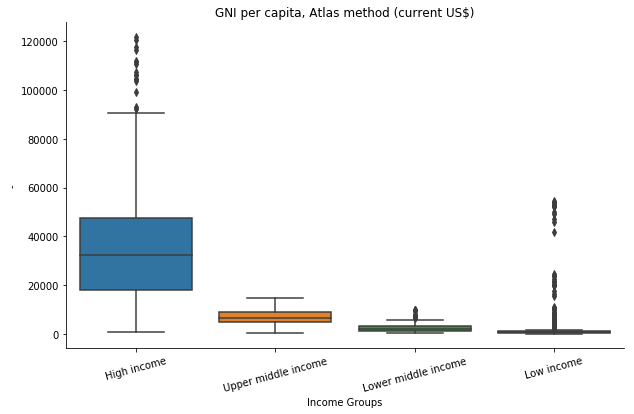


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income   Low income
mean          35758.25228       7070.349265       2465.318417  3026.123853


                Multiple Comparison of Means - Tukey HSD,FWER=0.05                
       group1              group2         meandiff     lower       upper    reject
----------------------------------------------------------------------------------
    High income          Low income     -32732.1284 -34803.2316 -30661.0253  True 
    High income     Lower middle income -33292.9339 -35202.2766 -31383.5911  True 
    High income     Upper middle income  -28687.903 -30631.4234 -26744.3827  True 
     Low income     Lower middle income  -560.8054   -2685.9008  1564.2899  False 
     Low income     Upper middle income  4044.2254   1888.3701   6200.0807   True 
Lower middle income U

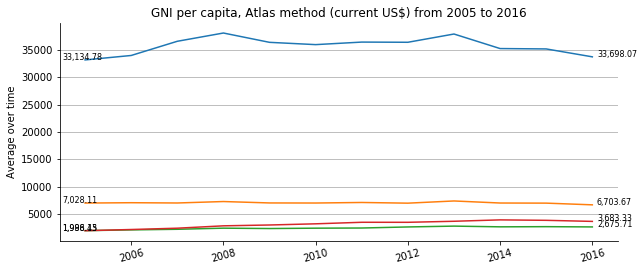

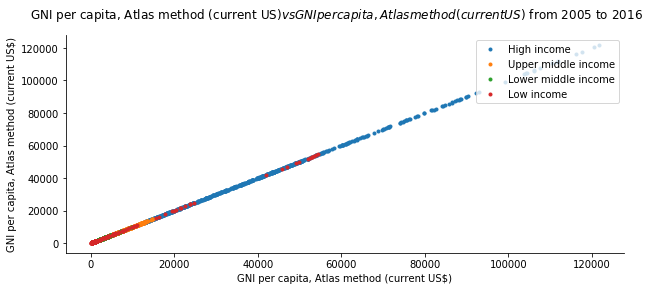

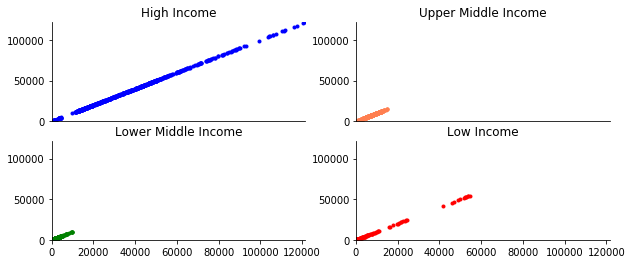

GNI per capita, Atlas method (current US$) and GNI per capita, Atlas method (current US$) are correlated by:
1.0000 with a p-value of 0.0 among all income groups
1.0000 with a p-value of 0.0 among High income countries.
1.0000 with a p-value of 0.0 among Upper middle income countries.
1.0000 with a p-value of 0.0 among Lower middle income countries.
1.0000 with a p-value of 0.0 among Low income countries.


In [108]:
view('GNI per capita, Atlas method (current US$)')

External balance on goods and services (formerly resource balance) equals exports of goods and services minus imports of goods and services (previously nonfactor services).


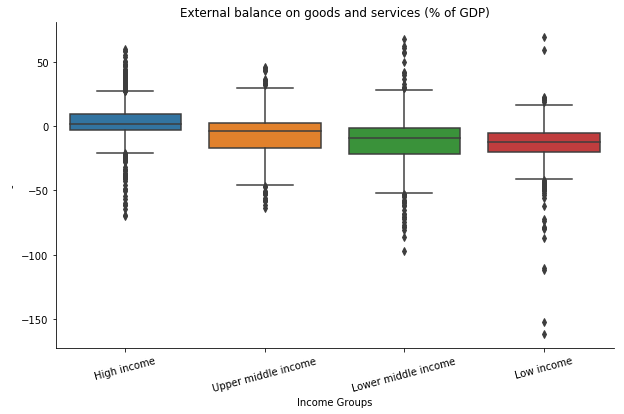


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             3.525089         -6.288411        -12.497753  -14.627521


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -18.1526 -21.1864 -15.1188  True 
    High income     Lower middle income -16.0228 -18.8407 -13.205   True 
    High income     Upper middle income -9.8135  -12.6342 -6.9928   True 
     Low income     Lower middle income  2.1298  -1.0307   5.2902  False 
     Low income     Upper middle income  8.3391   5.1761  11.5021   True 
Lower middle income Upper middle income  6.2093   3.2529   9.1658   True 
---------------------

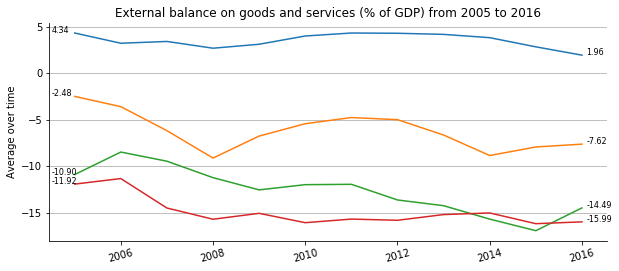

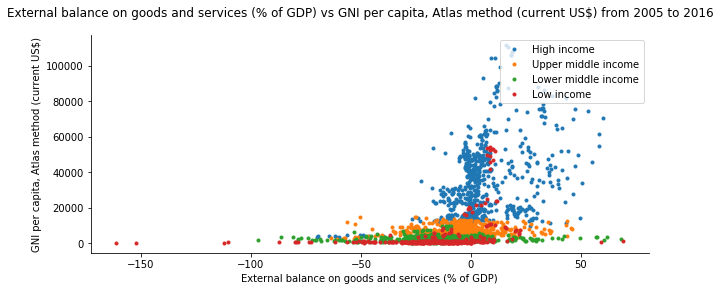

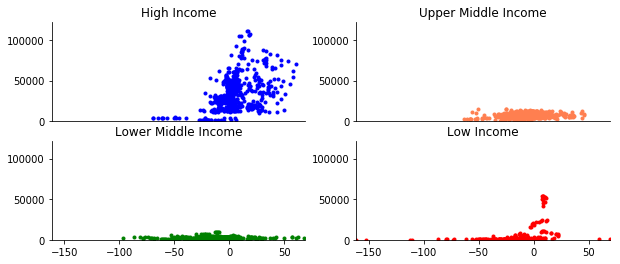

External balance on goods and services (% of GDP) and GNI per capita, Atlas method (current US$) are correlated by:
0.3790 with a p-value of 4.46775187636122e-84 among all income groups
0.3342 with a p-value of 5.392157729599261e-22 among High income countries.
0.1990 with a p-value of 1.90893447465996e-06 among Upper middle income countries.
0.0120 with a p-value of 0.7667239730936735 among Lower middle income countries.
0.2735 with a p-value of 1.715108380781885e-09 among Low income countries.


In [46]:
view('External balance on goods and services (% of GDP)')

Feature Definition:
Annual percentage growth rate of GDP at market prices based on constant local currency. Aggregates are based on constant 2010 U.S. dollars. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources.


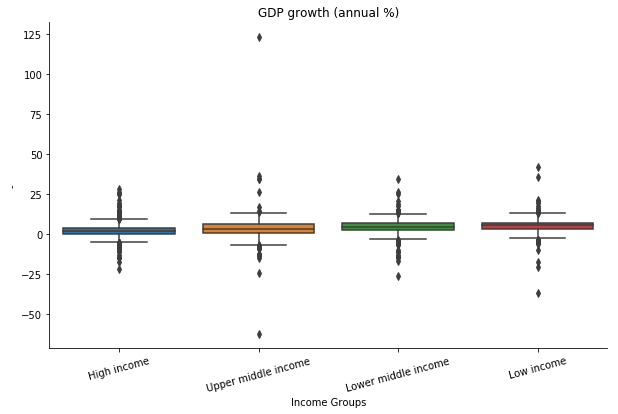


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             2.155708          3.509298          4.818868    5.273053


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      3.1173   2.2543  3.9804  True 
    High income     Lower middle income  2.6632   1.8739  3.4524  True 
    High income     Upper middle income  1.3536   0.5516  2.1556  True 
     Low income     Lower middle income -0.4542  -1.3565  0.4481 False 
     Low income     Upper middle income -1.7638  -2.6772 -0.8503  True 
Lower middle income Upper middle income -1.3096  -2.1537 -0.4655  True 
---------------------------------------

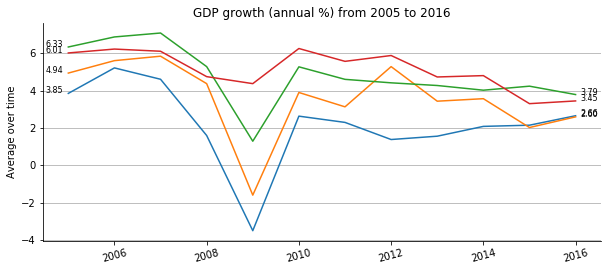

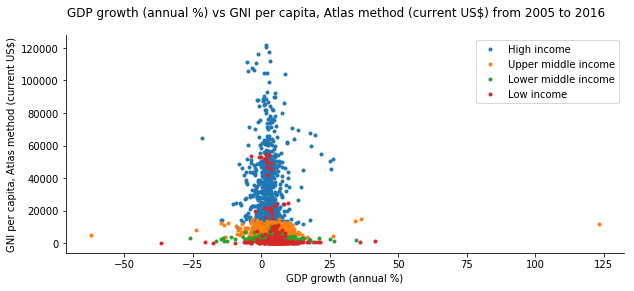

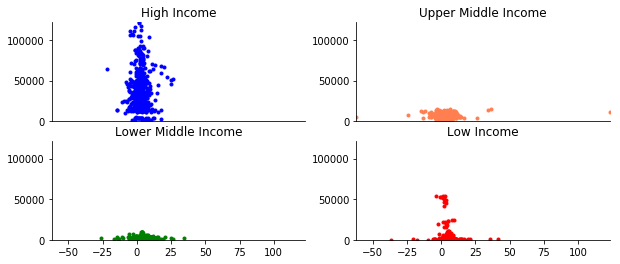

GDP growth (annual %) and GNI per capita, Atlas method (current US$) are correlated by:
-0.1423 with a p-value of 1.747905377664336e-12 among all income groups
-0.0119 with a p-value of 0.7384801264396754 among High income countries.
0.0753 with a p-value of 0.07412375769601592 among Upper middle income countries.
-0.1420 with a p-value of 0.0004080323949938428 among Lower middle income countries.
-0.1394 with a p-value of 0.002475793231876941 among Low income countries.


In [103]:
view('GDP growth (annual %)')

## Gender Issues

Women in parliaments are the percentage of parliamentary seats in a single or lower chamber held by women.


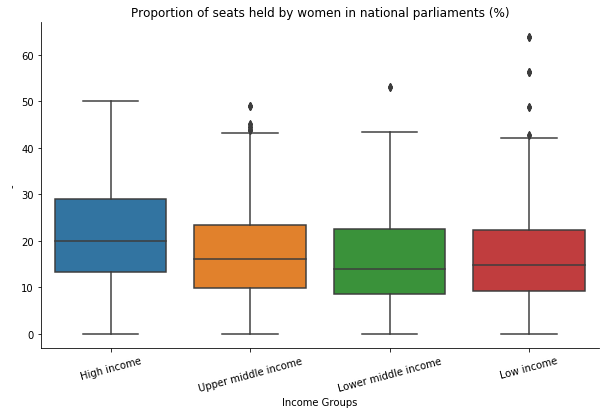


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            21.318945         17.452311         15.985763   17.334146


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income     -3.9848   -5.761 -2.2086  True 
    High income     Lower middle income -5.3332  -6.9842 -3.6821  True 
    High income     Upper middle income -3.8666  -5.5554 -2.1778  True 
     Low income     Lower middle income -1.3484  -3.1411  0.4443 False 
     Low income     Upper middle income  0.1182  -1.7094  1.9457 False 
Lower middle income Upper middle income  1.4665  -0.2396  3.1727 False 
---------------------------------------

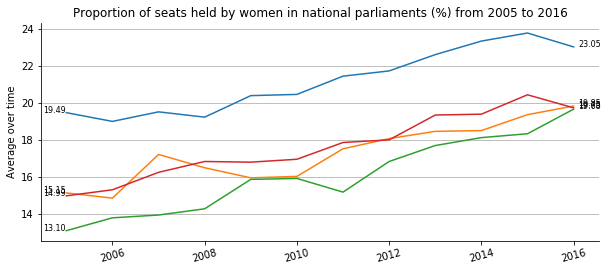

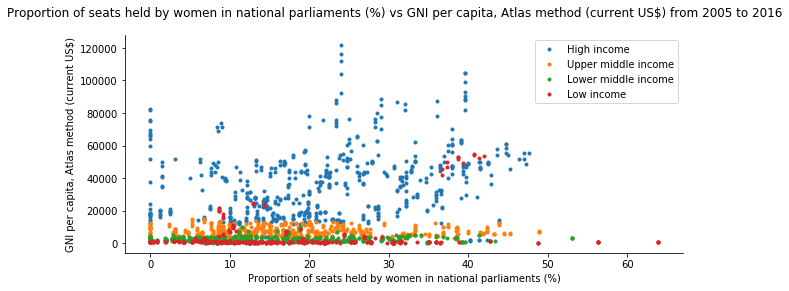

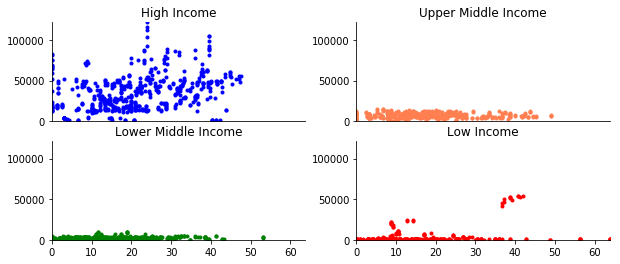

Proportion of seats held by women in national parliaments (%) and GNI per capita, Atlas method (current US$) are correlated by:
0.2376 with a p-value of 1.2874472853653604e-32 among all income groups
0.3007 with a p-value of 6.623460723613301e-18 among High income countries.
-0.0089 with a p-value of 0.8335185362080417 among Upper middle income countries.
0.0211 with a p-value of 0.6015210068551053 among Lower middle income countries.
0.2339 with a p-value of 3.002003111937773e-07 among Low income countries.


In [21]:
view('Proportion of seats held by women in national parliaments (%)')

## Education

Duration of compulsory education is the number of years that children are legally obliged to attend school.


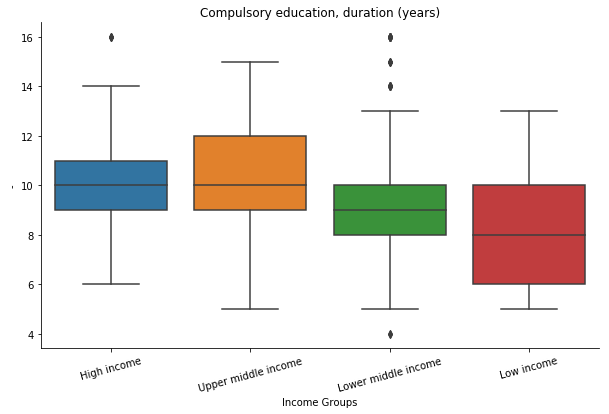


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             10.05891         10.160714          9.325142    8.146283


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income     -1.9126  -2.2461 -1.5792  True 
    High income     Lower middle income -0.7338  -1.0446  -0.423  True 
    High income     Upper middle income  0.1018  -0.2133  0.4169 False 
     Low income     Lower middle income  1.1789   0.8279  1.5298  True 
     Low income     Upper middle income  2.0144   1.6596  2.3692  True 
Lower middle income Upper middle income  0.8356   0.502   1.1692  True 
---------------------------------------

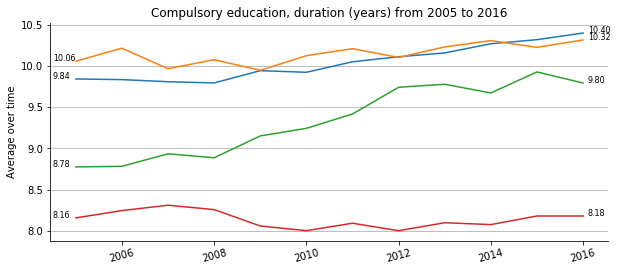

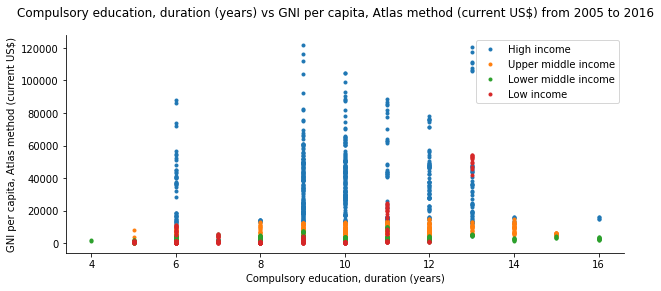

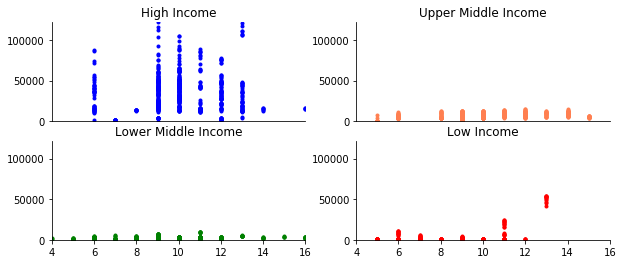

Compulsory education, duration (years) and GNI per capita, Atlas method (current US$) are correlated by:
0.1888 with a p-value of 5.5887564579513896e-21 among all income groups
0.0310 with a p-value of 0.38513342524902794 among High income countries.
0.3413 with a p-value of 7.408238461344181e-17 among Upper middle income countries.
0.1549 with a p-value of 0.00011393169263356323 among Lower middle income countries.
0.4632 with a p-value of 2.5289846993178565e-26 among Low income countries.


In [22]:
view('Compulsory education, duration (years)')

## Access to Advanced Communications

Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.


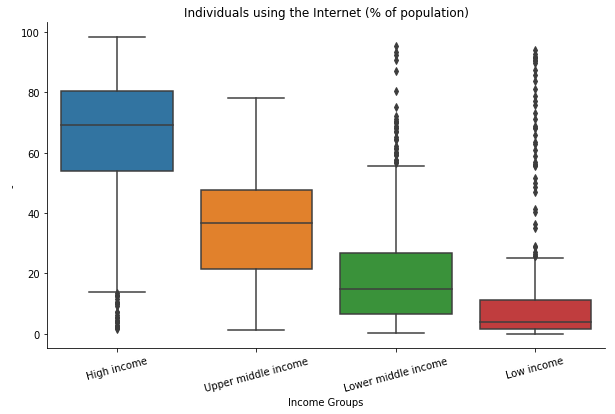


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            64.617978         35.260705         19.294008   11.006308


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -53.6117 -56.5691 -50.6543  True 
    High income     Lower middle income -45.324  -48.0465 -42.6015  True 
    High income     Upper middle income -29.3573 -32.1893 -26.5253  True 
     Low income     Lower middle income  8.2877   5.2084   11.367   True 
     Low income     Upper middle income 24.2544  21.0779  27.4309   True 
Lower middle income Upper middle income 15.9667  13.0076  18.9258   True 
---------------------

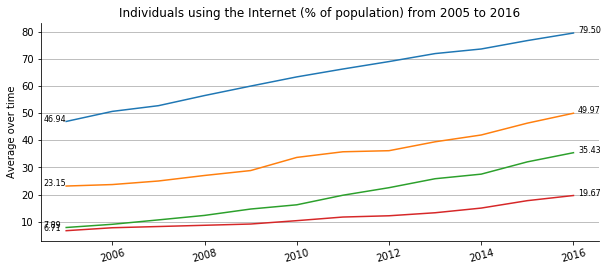

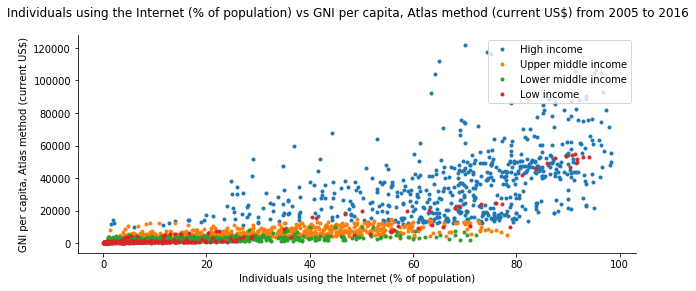

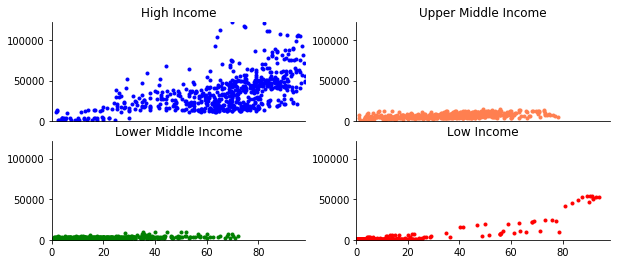

Individuals using the Internet (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.6979 with a p-value of 0.0 among all income groups
0.5088 with a p-value of 4.807916171862886e-53 among High income countries.
0.4898 with a p-value of 2.267318918926157e-35 among Upper middle income countries.
0.4523 with a p-value of 2.1894581393560833e-32 among Lower middle income countries.
0.8687 with a p-value of 1.331343529485874e-144 among Low income countries.


In [23]:
view('Individuals using the Internet (% of population)')

Mobile cellular telephone subscriptions are subscriptions to a public mobile telephone service that provide access to the PSTN using cellular technology. The indicator includes (and is split into) the number of postpaid subscriptions, and the number of active prepaid accounts (i.e. that have been used during the last three months). The indicator applies to all mobile cellular subscriptions that offer voice communications. It excludes subscriptions via data cards or USB modems, subscriptions to public mobile data services, private trunked mobile radio, telepoint, radio paging and telemetry services.


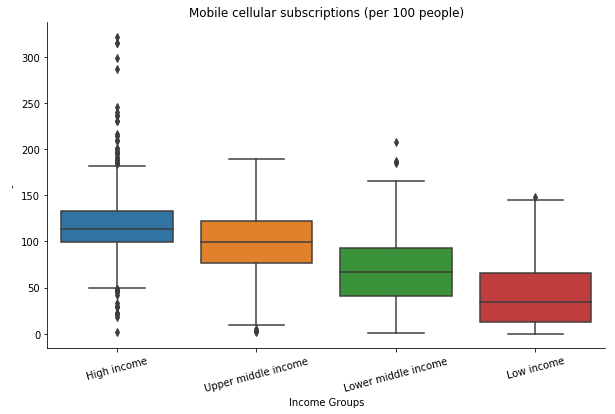


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean           117.516847         99.054331         68.505605   43.549679


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -73.9672 -79.6132 -68.3211  True 
    High income     Lower middle income -49.0112 -54.2383 -43.7842  True 
    High income     Upper middle income -18.4625 -23.8551 -13.0699  True 
     Low income     Lower middle income 24.9559  19.1213  30.7906   True 
     Low income     Upper middle income 55.5047  49.5212  61.4881   True 
Lower middle income Upper middle income 30.5487   24.959  36.1385   True 
---------------------

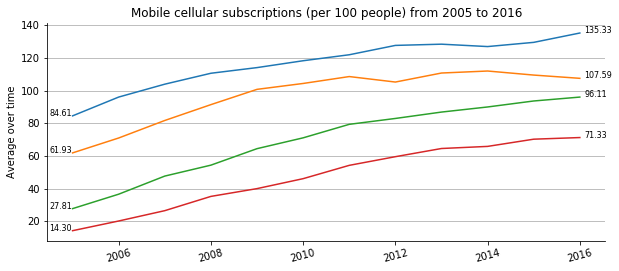

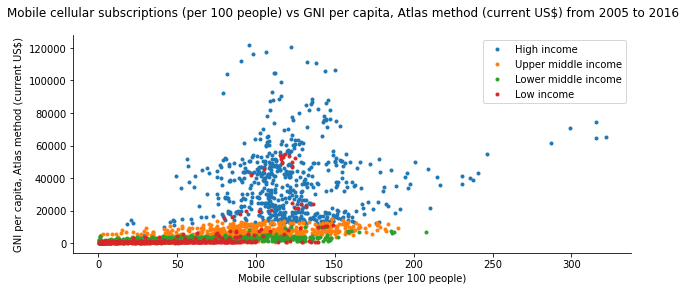

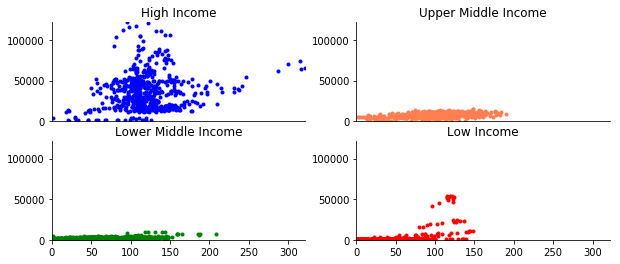

Mobile cellular subscriptions (per 100 people) and GNI per capita, Atlas method (current US$) are correlated by:
0.4345 with a p-value of 9.088149127207781e-113 among all income groups
0.1471 with a p-value of 3.436942232237461e-05 among High income countries.
0.3993 with a p-value of 5.2672488430637294e-23 among Upper middle income countries.
0.4932 with a p-value of 4.3993626773884463e-39 among Lower middle income countries.
0.4898 with a p-value of 1.1424280335643042e-29 among Low income countries.


In [24]:
view('Mobile cellular subscriptions (per 100 people)')

## Environment, Resources and Population

Access to electricity is the percentage of population with access to electricity. Electrification data are collected from industry, national surveys and international sources.


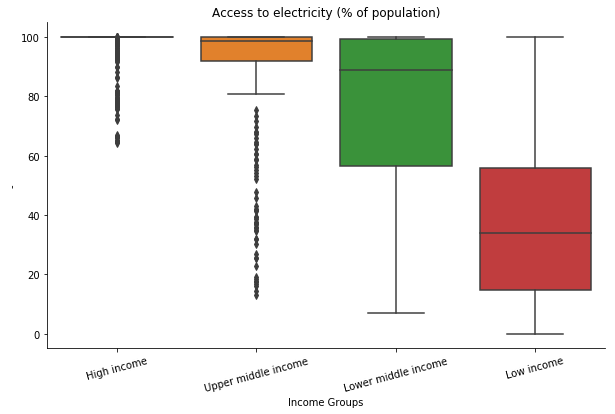


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            98.572428         91.663728         75.744472   40.819318


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -57.7531 -60.9448 -54.5614  True 
    High income     Lower middle income -22.828  -25.7714 -19.8845  True 
    High income     Upper middle income -6.9087  -9.9496  -3.8678   True 
     Low income     Lower middle income 34.9252  31.5721  38.2782   True 
     Low income     Upper middle income 50.8444  47.4055  54.2833   True 
Lower middle income Upper middle income 15.9193  12.7094  19.1291   True 
---------------------

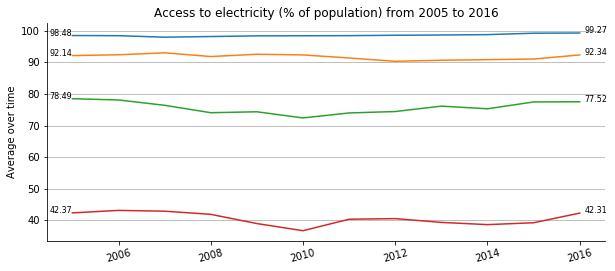

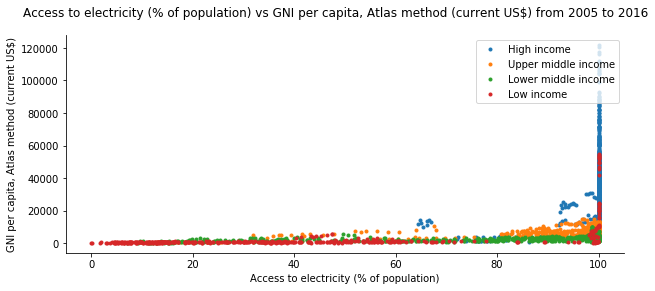

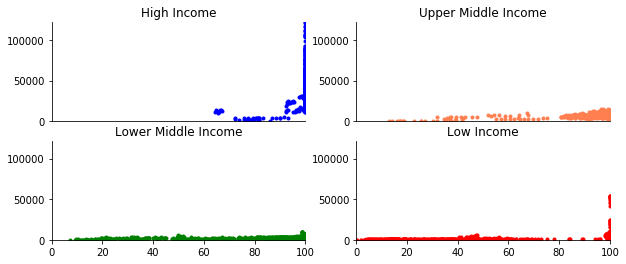

Access to electricity (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4064 with a p-value of 1.5951065616821503e-97 among all income groups
0.3633 with a p-value of 5.790836785633682e-26 among High income countries.
0.4936 with a p-value of 5.625861897776765e-36 among Upper middle income countries.
0.5072 with a p-value of 1.379690299848495e-41 among Lower middle income countries.
0.4856 with a p-value of 4.038585244098079e-29 among Low income countries.


In [25]:
view('Access to electricity (% of population)')

Access to clean fuels and technologies for cooking is the proportion of total population primarily using clean cooking fuels and technologies for cooking. Under WHO guidelines, kerosene is excluded from clean cooking fuels.


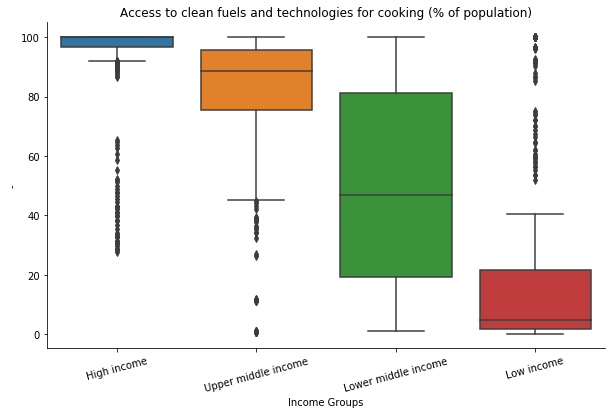


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            94.583547         80.291518         50.063513   19.755579


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -74.828  -78.9067 -70.7493  True 
    High income     Lower middle income  -44.52  -48.3325 -40.7075  True 
    High income     Upper middle income -14.292  -18.2686 -10.3155  True 
     Low income     Lower middle income 30.3079  26.2219   34.394   True 
     Low income     Upper middle income 60.5359  56.2964  64.7754   True 
Lower middle income Upper middle income  30.228  26.2439  34.2121   True 
---------------------

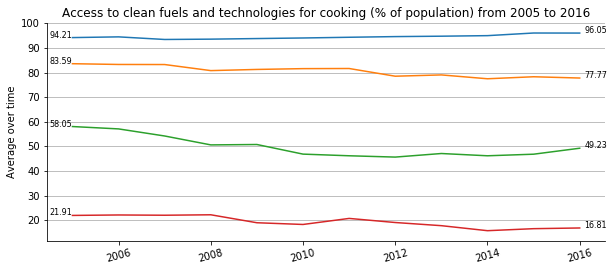

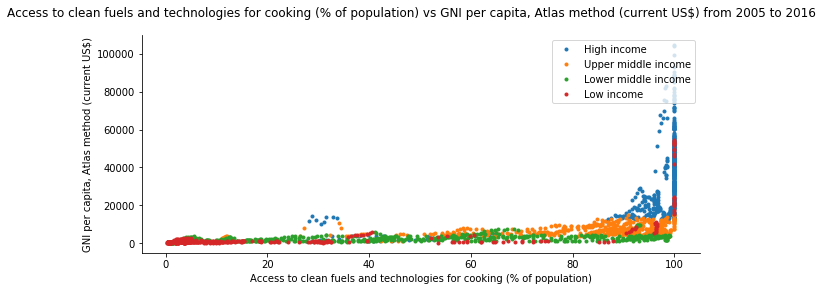

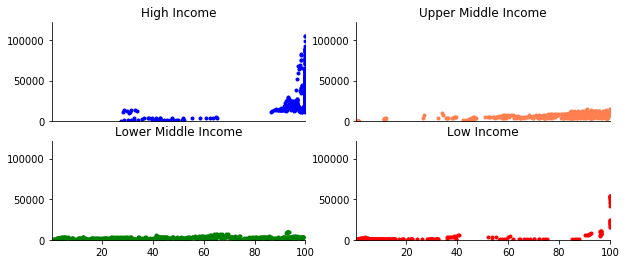

Access to clean fuels and technologies for cooking (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4787 with a p-value of 8.624504407960034e-140 among all income groups
0.3899 with a p-value of 5.62837296226956e-30 among High income countries.
0.5545 with a p-value of 8.952702548074582e-47 among Upper middle income countries.
0.4442 with a p-value of 3.602751016241144e-31 among Lower middle income countries.
0.6551 with a p-value of 8.083655725937041e-59 among Low income countries.


In [26]:
view('Access to clean fuels and technologies for cooking (% of population)')

Total natural resources rents are the sum of oil rents, natural gas rents, coal rents (hard and soft), mineral rents, and forest rents.


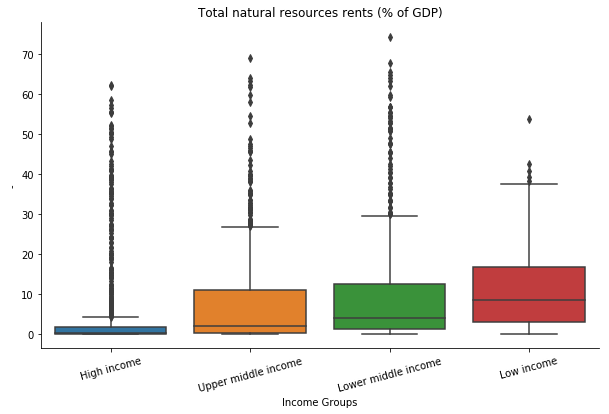


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             5.428989          8.111624           9.90203   10.955909


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      5.5269   3.6007  7.4531  True 
    High income     Lower middle income  4.473    2.7168  6.2293  True 
    High income     Upper middle income  2.6826   0.8898  4.4755  True 
     Low income     Lower middle income -1.0539  -3.0588  0.9511 False 
     Low income     Upper middle income -2.8443  -4.8814 -0.8072  True 
Lower middle income Upper middle income -1.7904  -3.6676  0.0868 False 
---------------------------------------

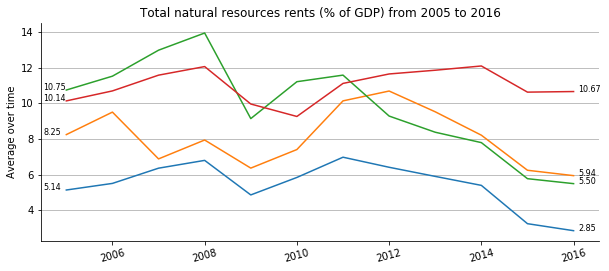

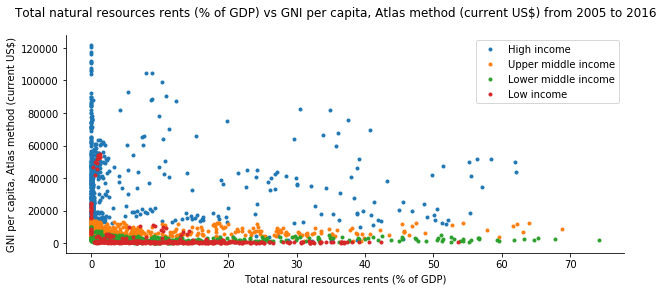

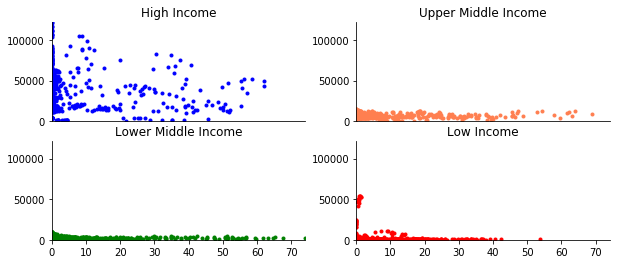

Total natural resources rents (% of GDP) and GNI per capita, Atlas method (current US$) are correlated by:
-0.1567 with a p-value of 7.288705682814715e-15 among all income groups
-0.0951 with a p-value of 0.007600894818105863 among High income countries.
-0.0472 with a p-value of 0.26335943944172435 among Upper middle income countries.
-0.1528 with a p-value of 0.00014019044928388787 among Lower middle income countries.
-0.2619 with a p-value of 8.487266717427949e-09 among Low income countries.


In [27]:
view('Total natural resources rents (% of GDP)')

Urban population refers to people living in urban areas as defined by national statistical offices. The data are collected and smoothed by United Nations Population Division.


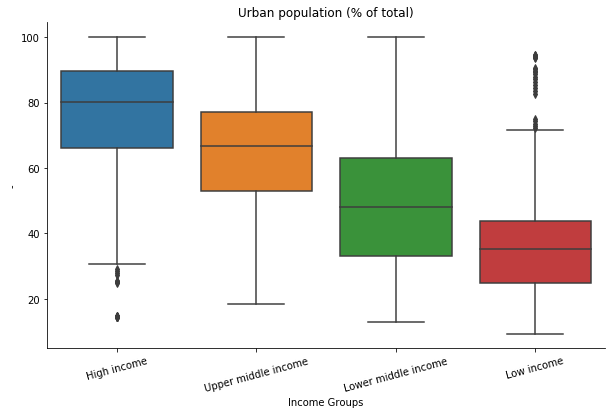


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             75.69674         63.760207         48.225244   37.646914


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -38.0498 -40.8931 -35.2065  True 
    High income     Lower middle income -27.4715 -30.0848 -24.8582  True 
    High income     Upper middle income -11.9365 -14.6166 -9.2565   True 
     Low income     Lower middle income 10.5783   7.5922  13.5644   True 
     Low income     Upper middle income 26.1133  23.0686   29.158   True 
Lower middle income Upper middle income  15.535  12.7039  18.3661   True 
---------------------

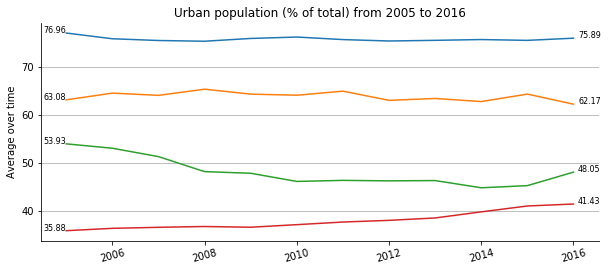

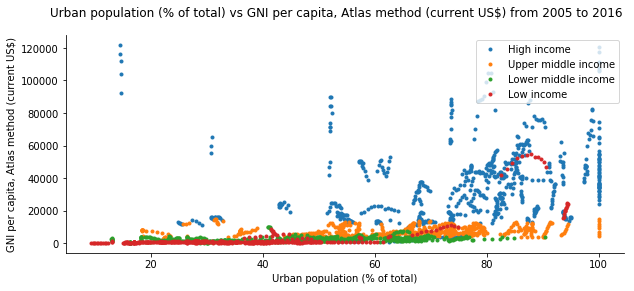

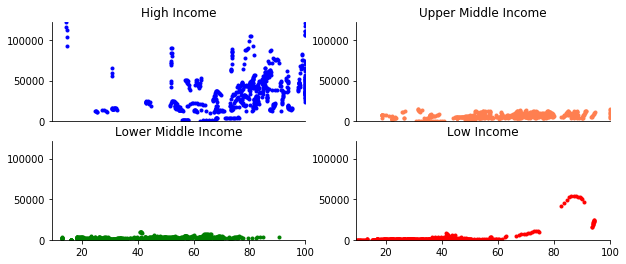

Urban population (% of total) and GNI per capita, Atlas method (current US$) are correlated by:
0.4989 with a p-value of 1.776957814784926e-153 among all income groups
0.2282 with a p-value of 9.318433394548994e-11 among High income countries.
0.3088 with a p-value of 6.262299480530386e-14 among Upper middle income countries.
0.2897 with a p-value of 2.2628879221108722e-13 among Lower middle income countries.
0.6686 with a p-value of 4.649712011113799e-62 among Low income countries.


In [28]:
view('Urban population (% of total)')

## Social Protection and Labor

Labor force participation rate is the proportion of the population ages 15-64 that is economically active: all people who supply labor for the production of goods and services during a specified period.


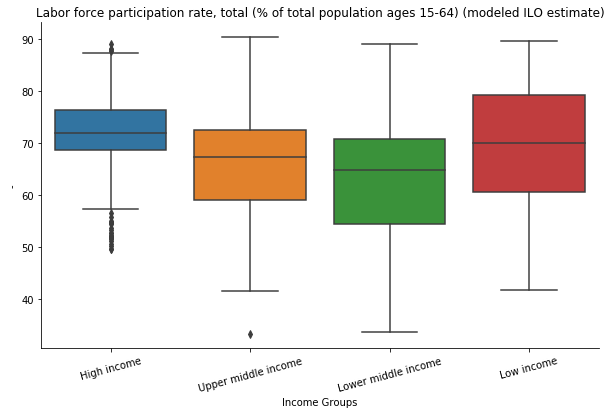


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            72.000135         65.146433         62.983934   68.915026


           Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper  reject
------------------------------------------------------------------------
    High income          Low income     -3.0851  -4.6618  -1.5084  True 
    High income     Lower middle income -9.0162  -10.4967 -7.5357  True 
    High income     Upper middle income -6.8537  -8.4236  -5.2838  True 
     Low income     Lower middle income -5.9311  -7.5416  -4.3205  True 
     Low income     Upper middle income -3.7686  -5.4618  -2.0754  True 
Lower middle income Upper middle income  2.1625   0.5586   3.7664  True 
------------------------------

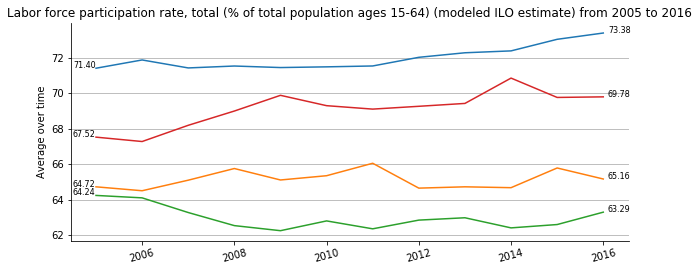

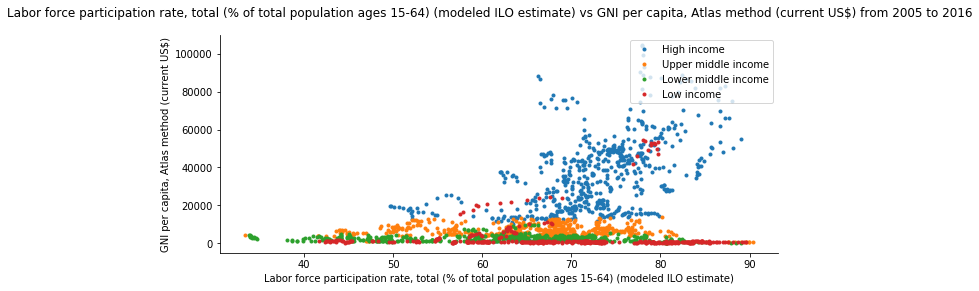

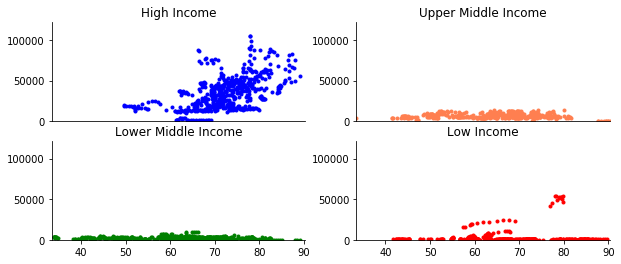

Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.2864 with a p-value of 3.2655868987242114e-47 among all income groups
0.4236 with a p-value of 1.284253138132136e-35 among High income countries.
-0.0261 with a p-value of 0.5358989863026586 among Upper middle income countries.
-0.1383 with a p-value of 0.000578169187481388 among Lower middle income countries.
0.0586 with a p-value of 0.20551623408629766 among Low income countries.


In [29]:
view('Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)')

Contributing family workers are those workers who hold "self-employment jobs" as own-account workers in a market-oriented establishment operated by a related person living in the same household.


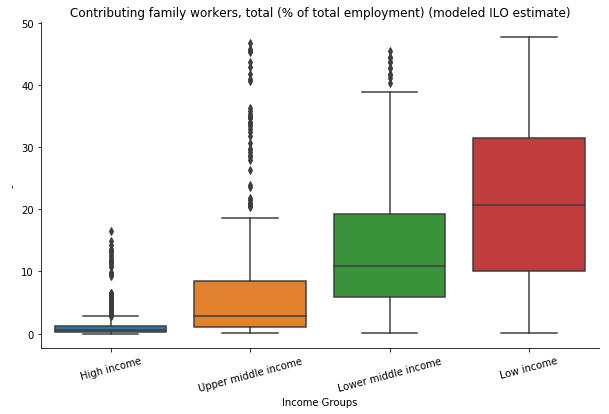


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             1.419174          6.690796         13.980521   20.786294


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     19.3671   17.913  20.8213   True 
    High income     Lower middle income 12.5613   11.196  13.9267   True 
    High income     Upper middle income  5.2716   3.8237   6.7195   True 
     Low income     Lower middle income -6.8058  -8.2911  -5.3204   True 
     Low income     Upper middle income -14.0955 -15.6571 -12.5339  True 
Lower middle income Upper middle income -7.2897   -8.769  -5.8105   True 
---------------------

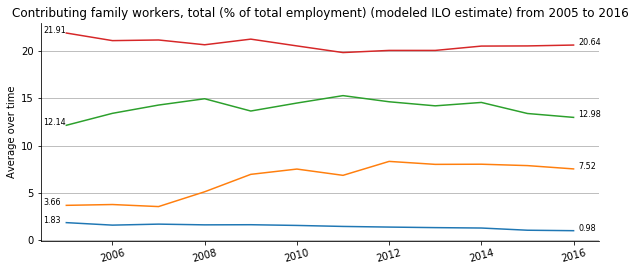

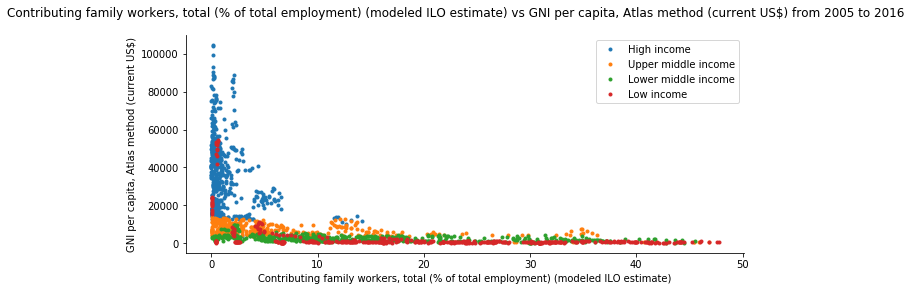

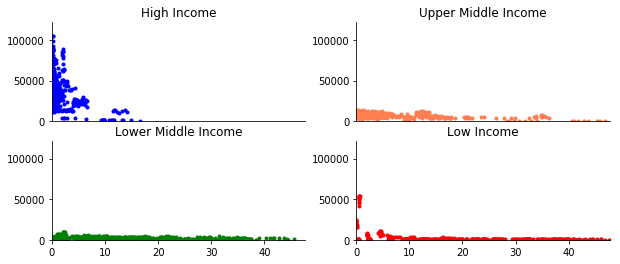

Contributing family workers, total (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4149 with a p-value of 5.473345006247806e-102 among all income groups
-0.3164 with a p-value of 9.218731362496206e-20 among High income countries.
-0.4042 with a p-value of 1.4031557985983642e-23 among Upper middle income countries.
-0.4216 with a p-value of 6.037532176502789e-28 among Lower middle income countries.
-0.3807 with a p-value of 1.2764322495462951e-17 among Low income countries.


In [30]:
view('Contributing family workers, total (% of total employment) (modeled ILO estimate)')

Age dependency ratio is the ratio of dependents--people younger than 15 or older than 64--to the working-age population--those ages 15-64. Data are shown as the proportion of dependents per 100 working-age population.


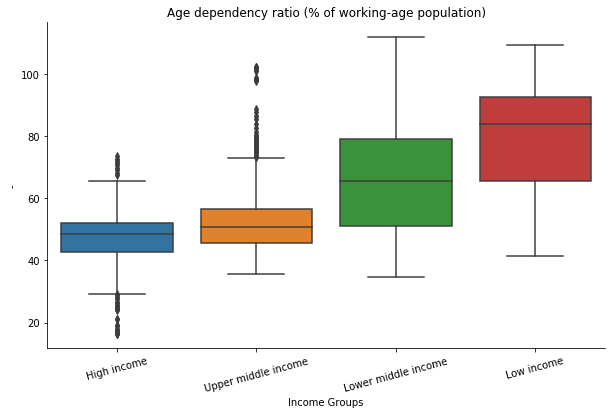


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            46.654693         53.314289         66.263432   78.912443


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     32.2577  30.0255   34.49    True 
    High income     Lower middle income 19.6087  17.5326  21.6848   True 
    High income     Upper middle income  6.6596   4.4902   8.829    True 
     Low income     Lower middle income -12.649  -14.9359 -10.3622  True 
     Low income     Upper middle income -25.5982  -27.97  -23.2263  True 
Lower middle income Upper middle income -12.9491 -15.1747 -10.7236  True 
---------------------

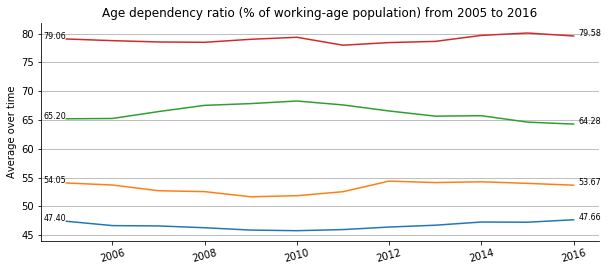

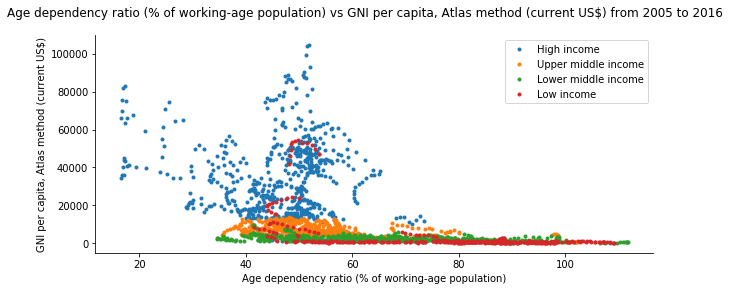

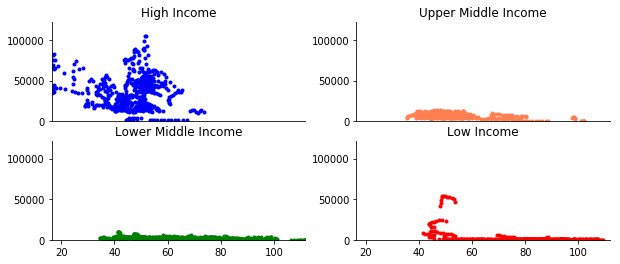

Age dependency ratio (% of working-age population) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4110 with a p-value of 5.987519352301555e-100 among all income groups
-0.0768 with a p-value of 0.031167972007244162 among High income countries.
-0.4305 with a p-value of 7.587900968806467e-27 among Upper middle income countries.
-0.4883 with a p-value of 3.216640879774157e-38 among Lower middle income countries.
-0.4329 with a p-value of 7.696028696171478e-23 among Low income countries.


In [31]:
view('Age dependency ratio (% of working-age population)')

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The agriculture sector consists of activities in agriculture, hunting, forestry and fishing, in accordance with division 1 (ISIC 2) or categories A-B (ISIC 3) or category A (ISIC 4).


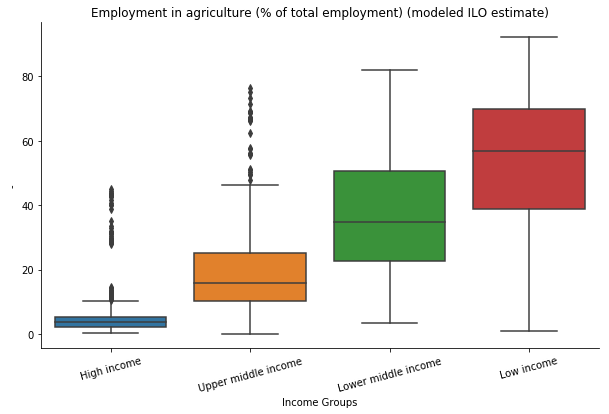


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             5.597595         19.979996          37.67798   52.999693


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     47.4021  44.9058  49.8984   True 
    High income     Lower middle income 32.0804  29.7364  34.4243   True 
    High income     Upper middle income 14.3824  11.8968   16.868   True 
     Low income     Lower middle income -15.3217 -17.8716 -12.7718  True 
     Low income     Upper middle income -33.0197 -35.7004 -30.339   True 
Lower middle income Upper middle income -17.698  -20.2374 -15.1585  True 
---------------------

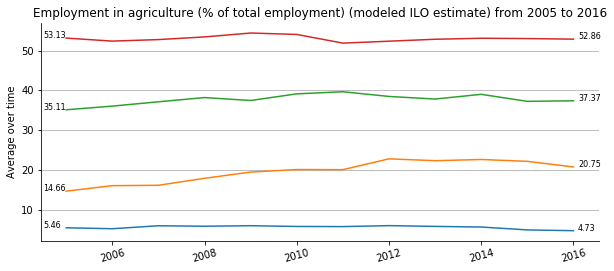

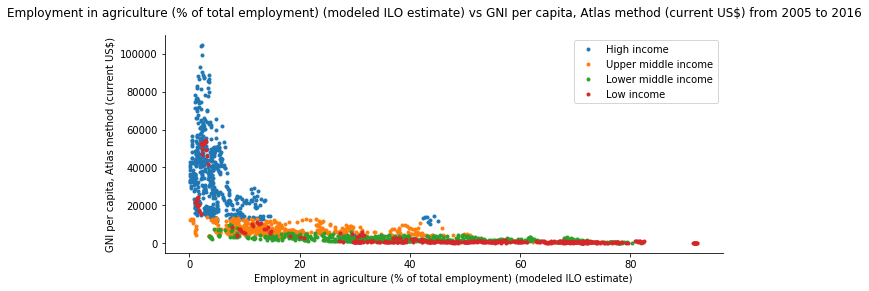

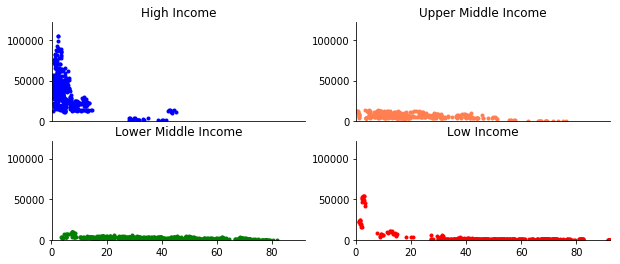

Employment in agriculture (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
-0.5252 with a p-value of 7.730936839086974e-173 among all income groups
-0.3874 with a p-value of 1.3845262645867078e-29 among High income countries.
-0.4774 with a p-value of 1.8818761831722548e-33 among Upper middle income countries.
-0.5962 with a p-value of 1.4785092035039706e-60 among Lower middle income countries.
-0.5751 with a p-value of 1.2036515915354133e-42 among Low income countries.


In [32]:
view('Employment in agriculture (% of total employment) (modeled ILO estimate)')

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The industry sector consists of mining and quarrying, manufacturing, construction, and public utilities (electricity, gas, and water), in accordance with divisions 2-5 (ISIC 2) or categories C-F (ISIC 3) or categories B-F (ISIC 4).


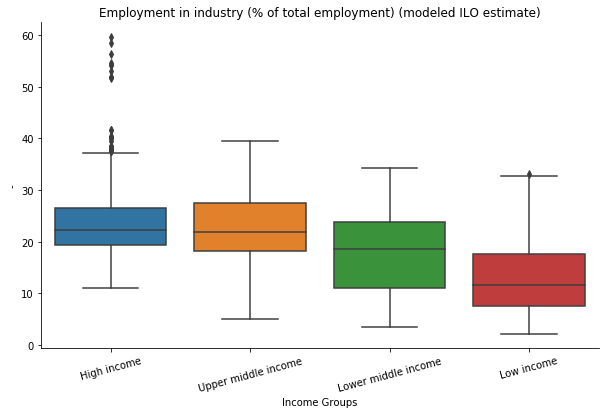


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            23.655494         22.327487         18.199334   12.977452


           Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper  reject
------------------------------------------------------------------------
    High income          Low income     -10.678  -11.7876 -9.5685  True 
    High income     Lower middle income -5.4562   -6.498  -4.4143  True 
    High income     Upper middle income  -1.328  -2.4328  -0.2232  True 
     Low income     Lower middle income  5.2219   4.0885   6.3553  True 
     Low income     Upper middle income   9.35    8.1585  10.5416  True 
Lower middle income Upper middle income  4.1282   2.9994   5.2569  True 
------------------------------

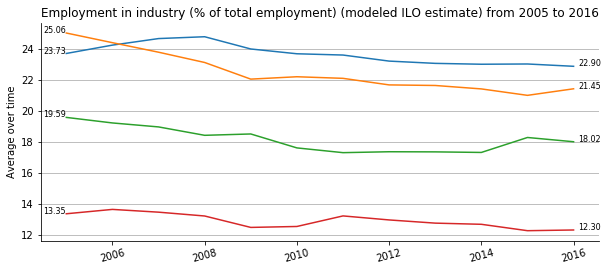

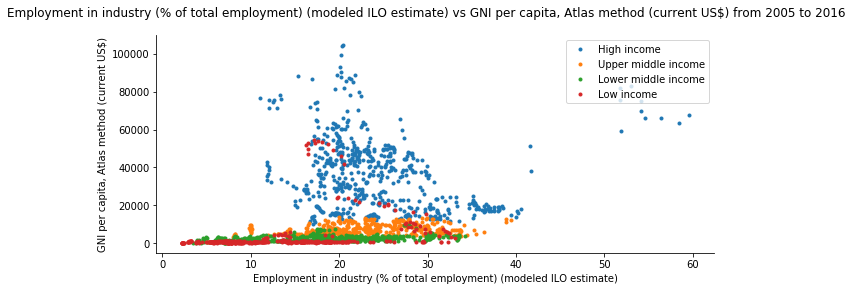

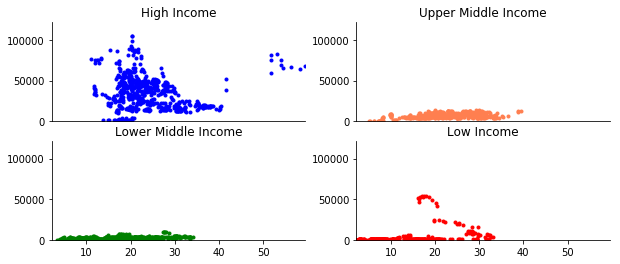

Employment in industry (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.2557 with a p-value of 1.11841123451996e-37 among all income groups
-0.0879 with a p-value of 0.013590248309826417 among High income countries.
0.3332 with a p-value of 4.2973882238122794e-16 among Upper middle income countries.
0.3785 with a p-value of 2.0292406829700785e-22 among Lower middle income countries.
0.2809 with a p-value of 5.922362964385547e-10 among Low income countries.


In [33]:
view('Employment in industry (% of total employment) (modeled ILO estimate)')

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The services sector consists of wholesale and retail trade and restaurants and hotels; transport, storage, and communications; financing, insurance, real estate, and business services; and community, social, and personal services, in accordance with divisions 6-9 (ISIC 2) or categories G-Q (ISIC 3) or categories G-U (ISIC 4).


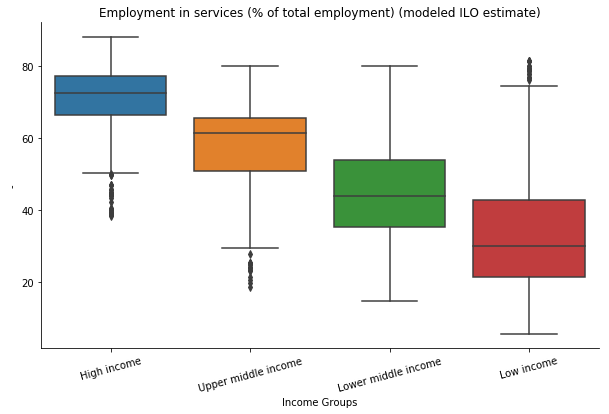


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            70.746946         57.692521           44.1227   34.022872


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -36.7241 -38.7121 -34.7361  True 
    High income     Lower middle income -26.6242 -28.4909 -24.7576  True 
    High income     Upper middle income -13.0544 -15.0339 -11.075   True 
     Low income     Lower middle income 10.0998   8.0692  12.1305   True 
     Low income     Upper middle income 23.6696  21.5348  25.8045   True 
Lower middle income Upper middle income 13.5698  11.5475  15.5922   True 
---------------------

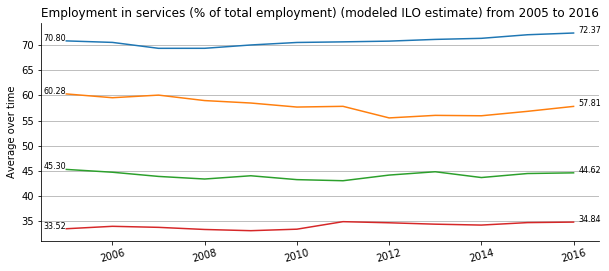

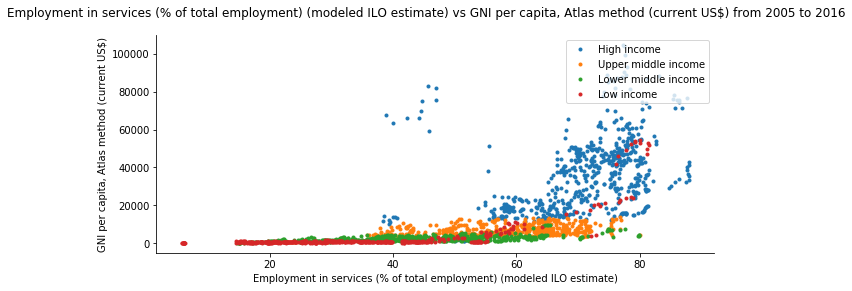

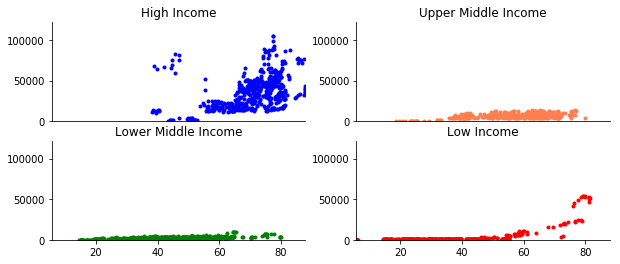

Employment in services (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.5559 with a p-value of 1.1433733008922625e-197 among all income groups
0.3665 with a p-value of 2.004347404526264e-26 among High income countries.
0.4108 with a p-value of 2.231083629420203e-24 among Upper middle income countries.
0.6085 with a p-value of 1.1374768511790138e-63 among Lower middle income countries.
0.6416 with a p-value of 9.421674173894713e-56 among Low income countries.


In [34]:
view('Employment in services (% of total employment) (modeled ILO estimate)')

# Health

Total fertility rate represents the number of children that would be born to a woman if she were to live to the end of her childbearing years and bear children in accordance with age-specific fertility rates of the specified year.


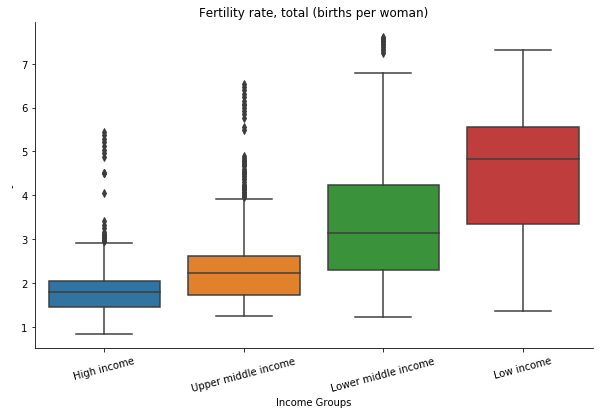


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             1.849139          2.407272          3.349717    4.439864


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      2.5907   2.4163  2.7651  True 
    High income     Lower middle income  1.5006   1.3382  1.663   True 
    High income     Upper middle income  0.5581   0.3885  0.7277  True 
     Low income     Lower middle income -1.0901  -1.2712 -0.9091  True 
     Low income     Upper middle income -2.0326  -2.2202  -1.845  True 
Lower middle income Upper middle income -0.9424  -1.1189  -0.766  True 
---------------------------------------

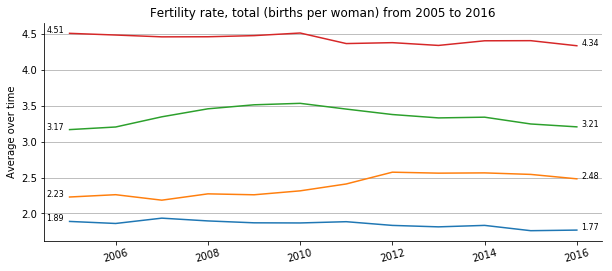

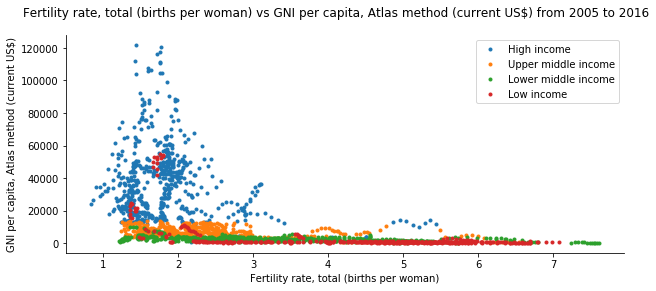

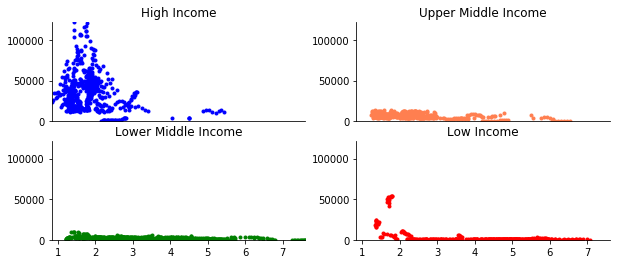

Fertility rate, total (births per woman) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4403 with a p-value of 4.704323858895944e-116 among all income groups
-0.2037 with a p-value of 8.165502456139758e-09 among High income countries.
-0.4294 with a p-value of 1.0419468469263636e-26 among Upper middle income countries.
-0.5028 with a p-value of 8.698291729507064e-41 among Lower middle income countries.
-0.4565 with a p-value of 1.5887847240453504e-25 among Low income countries.


In [35]:
view('Fertility rate, total (births per woman)')

Although, on average, life expectancy is higher among higher income countries, the minimum life expectancy among all income groups is on the rise per year.

### Life expectancy at birth, total (years)

1. Infant mortality rate rises almost exponentially as income groups change.  The average mortality rate for high income countries is 7.5 deaths per 1000 births, and rises to 19 for upper middle income, 33 for lower middle income, and 54 for low income countries.  This is likely due to the difference in access to basic needs and quality of life among the groups.


2. The difference in means is significant from income group to income group with low income countries having a mortality rate almosrt 8 times that of high income countries.


3. Although mortality rate is high among low income countries, mortality rates have consistently dropped yearly from 2005 to 2016 from an average of 59.28 deaths per 1000 births to 47.48.


4. Infant mortality rate is also negatively correlated to GNI per capital among all income groups with a pearson correlation score of 0.4431.

Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


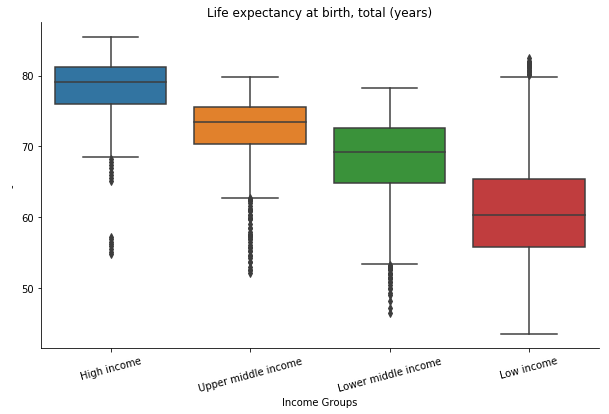


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            78.157077         72.084607         67.673122   61.267376


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -16.8897 -17.8123 -15.9671  True 
    High income     Lower middle income -10.484  -11.3433 -9.6246   True 
    High income     Upper middle income -6.0725  -6.9709   -5.174   True 
     Low income     Lower middle income  6.4057   5.4502   7.3613   True 
     Low income     Upper middle income 10.8172   9.8264  11.8081   True 
Lower middle income Upper middle income  4.4115   3.4792   5.3437   True 
---------------------

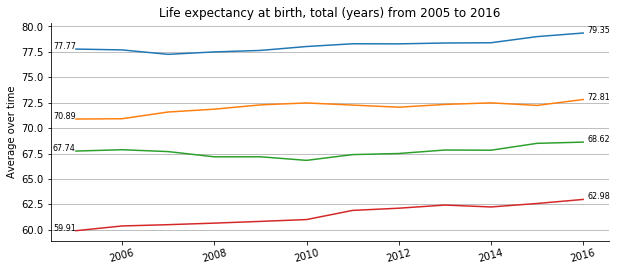

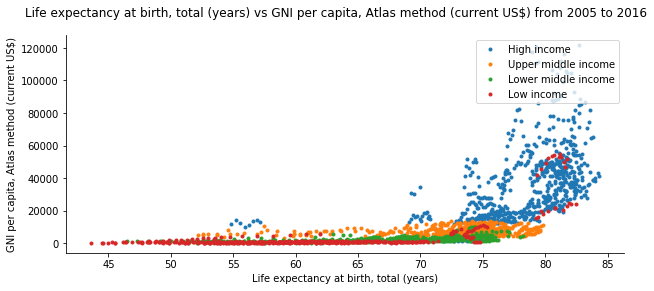

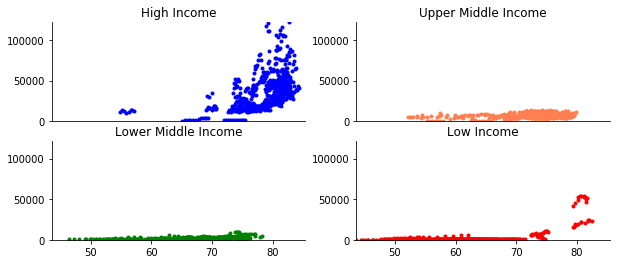

Life expectancy at birth, total (years) and GNI per capita, Atlas method (current US$) are correlated by:
0.5754 with a p-value of 9.141176832837525e-215 among all income groups
0.4711 with a p-value of 1.0063408604859943e-44 among High income countries.
0.3211 with a p-value of 5.448086720860001e-15 among Upper middle income countries.
0.5651 with a p-value of 2.874869530249883e-53 among Lower middle income countries.
0.5712 with a p-value of 5.81479790604006e-42 among Low income countries.


In [36]:
view('Life expectancy at birth, total (years)')

### Mortality rate, infant (per 1,000 live births)

1. Infant mortality rate rises almost exponentially as income groups change.  The average mortality rate for high income countries is 7.5 deaths per 1000 births, and rises to 19 for upper middle income, 33 for lower middle income, and 54 for low income countries.  This is likely due to the difference in access to basic needs and quality of life among the groups.


2. The difference in means is significant from income group to income group with low income countries having a mortality rate almosrt 8 times that of high income countries.


3. Although mortality rate is high among low income countries, mortality rates have consistently dropped yearly from 2005 to 2016 from an average of 59.28 deaths per 1000 births to 47.48.


4. Infant mortality rate is also negatively correlated to GNI per capital among all income groups with a pearson correlation score of 0.4431.

Infant mortality rate is the number of infants dying before reaching one year of age, per 1,000 live births in a given year.


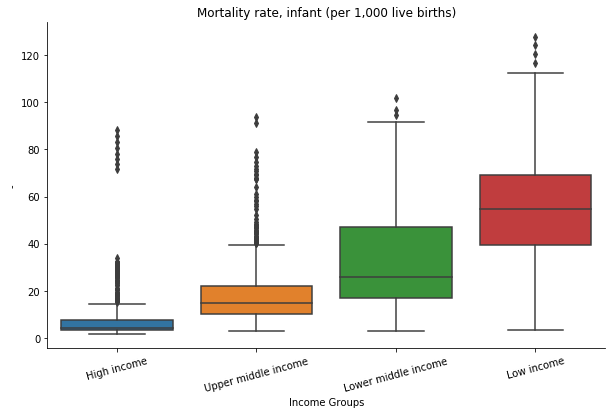


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             7.491133         19.089818         32.779221   53.965458


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     46.4743  43.5868  49.3618   True 
    High income     Lower middle income 25.2881  22.6023  27.9739   True 
    High income     Upper middle income 11.5987   8.8339  14.3634   True 
     Low income     Lower middle income -21.1862 -24.0666 -18.3059  True 
     Low income     Upper middle income -34.8756 -37.8297 -31.9215  True 
Lower middle income Upper middle income -13.6894 -16.4467 -10.9321  True 
---------------------

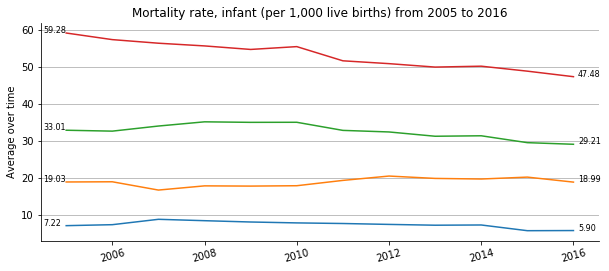

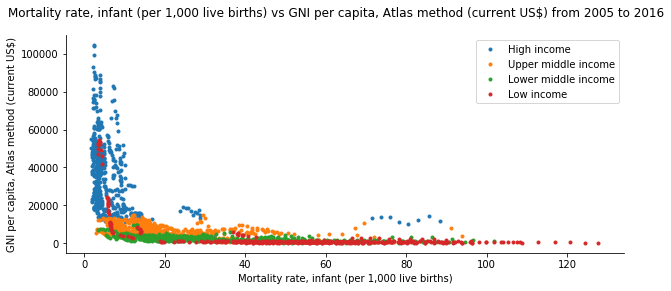

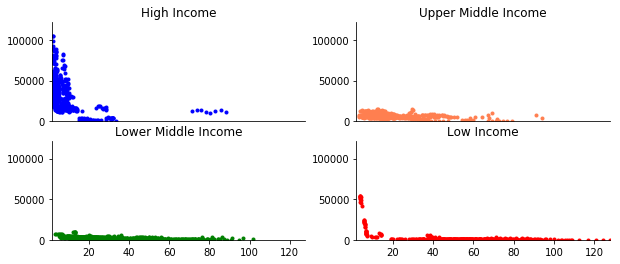

Mortality rate, infant (per 1,000 live births) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4431 with a p-value of 1.0230514970628339e-117 among all income groups
-0.3295 with a p-value of 2.1824476239910834e-21 among High income countries.
-0.4129 with a p-value of 1.247145676732291e-24 among Upper middle income countries.
-0.5489 with a p-value of 9.264347242955912e-50 among Lower middle income countries.
-0.4842 with a p-value of 6.041930014819053e-29 among Low income countries.


In [37]:
view('Mortality rate, infant (per 1,000 live births)')

### People using at least basic drinking water services (% of population)

1. Access to basic drinking water is prevalent among higher income countries with an average of over 90% of the population having access.  Lower income countries' access drops to 81% and in the lowest income countries, access to basic drinking water sharply declines to 64%.


2. The difference in means is significant from income group to income group with 30% more of the population in high income countries having access to basic drinking water than low income countries.


3. There is no significant change over time in access.


4. Access to basic drinking water is also correlated to GNI per capital among all income groups with a pearson correlation score of 0.4169

Indicator Definition: 

The percentage of people using at least basic water services.  This indicator encompasses both people using basic water services as well as those using safely managed water services.  Basic drinking water services is defined as drinking water from an improved source, provided collection time is not more than 30 minutes for a round trip.  Improved water sources include piped water, boreholes or tubewells, protected dug wells, protected springs, and packaged or delivered water.


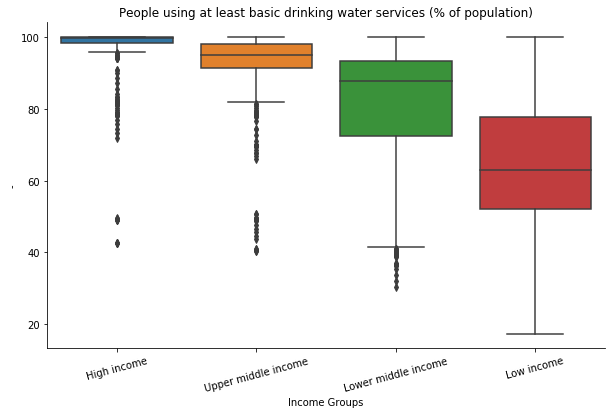


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            97.360528         92.084878         81.552672    63.95702


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -33.4035 -35.4957 -31.3113  True 
    High income     Lower middle income -15.8079 -17.7373 -13.8784  True 
    High income     Upper middle income -5.2756  -7.2544  -3.2969   True 
     Low income     Lower middle income 17.5957  15.3976  19.7937   True 
     Low income     Upper middle income 28.1279  25.8865  30.3692   True 
Lower middle income Upper middle income 10.5322   8.4419  12.6225   True 
---------------------

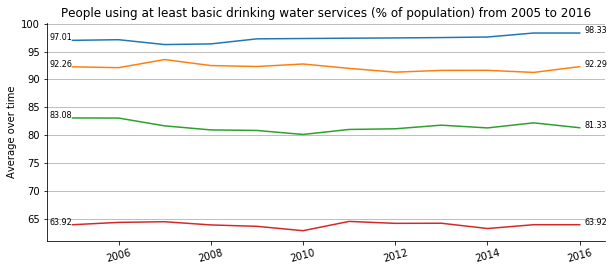

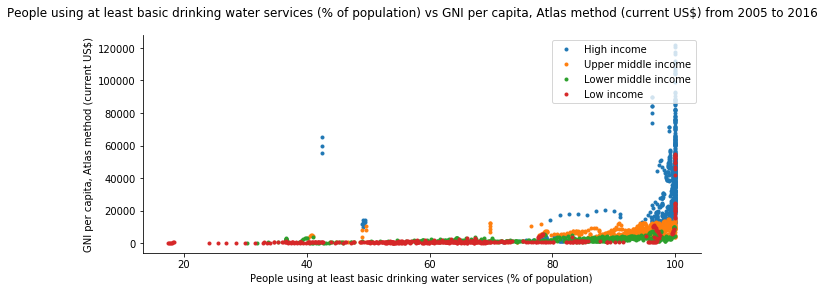

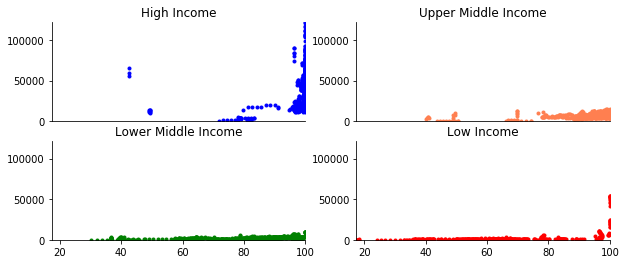

People using at least basic drinking water services (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4280 with a p-value of 4.294590707767397e-109 among all income groups
0.2833 with a p-value of 5.426315697327068e-16 among High income countries.
0.4140 with a p-value of 9.179359240396208e-25 among Upper middle income countries.
0.5202 with a p-value of 5.209698312099706e-44 among Lower middle income countries.
0.4390 with a p-value of 1.6053243259751185e-23 among Low income countries.


In [111]:
view('People using at least basic drinking water services (% of population)') #-#

numbers
percents
wdi_pivot
wdi
high
upper_middle
lower_middle
low
income_groups